In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from progressbar import ProgressBar
import time

%run ../global_variables.py ./
%run ../global_functions.py ./

<div class="alert alert-block alert-info">
This notebook saves hydrological variables aggregated at the basin scale for all available datasets
</div>

# 1. Run through datasets and selected basins

We select the basins we want to study. `NB_RUNOFF` is the number of runoff stations from [GRDC](https://www.bafg.de/SharedDocs/ExterneLinks/GRDC/grdc_stations_ftp.html) operating at least 1 year between 2003 and 2017, inside each basin.

In [2]:
# only if we are looking at amazon sub-basins
#basins=geopandas.read_file('../datasets/basins/amazon_subbasins.shp')
#basins.set_index('NAME',inplace=True)

In [3]:
basins=geopandas.read_file("../datasets/basins/basins_with_approx_climate_zones.shp")
basins.set_index("NAME",inplace=True)
basins.drop(['CONTINENT', 'OCEAN', 'CLIMATE_AR','COLOR_HEX'],axis=1,inplace=True)

In [4]:
basins

,RASTAREA,MAIN_CLIMA,geometry
NAME,,,
WINISK,65635.3,D,"POLYGON ((-87.24167 52.32500, -87.24223 52.314..."
COPPER,65704.3,D,"POLYGON ((-140.15833 61.00000, -140.15890 60.9..."
NOTTAWAY,66053.1,D,"MULTIPOLYGON (((-73.85417 50.00833, -73.85089 ..."
TALAS,66179.8,B,"POLYGON ((73.61250 42.33333, 73.60612 42.33277..."
MARONI,66408.4,A,"POLYGON ((-53.08750 3.20833, -53.08508 3.20798..."
...,...,...,...
Tibetan plateau,590841.4,E,"POLYGON ((91.41667 35.80000, 91.51172 35.76596..."
Western Plateau,1998005.0,B,"POLYGON ((134.56667 -16.38750, 134.62917 -16.4..."
Puna de Atacama plateau,101842.2,E,"MULTIPOLYGON (((-68.88750 -26.79167, -68.83750..."


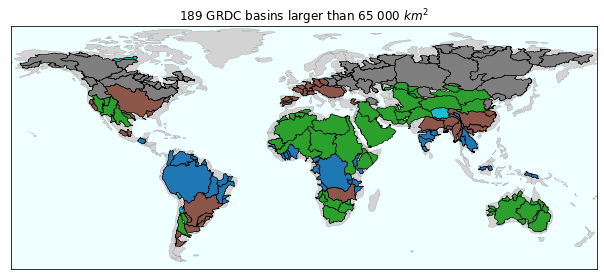

In [5]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins.plot(ax=ax,column='MAIN_CLIMA',edgecolor='black',linewidth=0.5)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('{} GRDC basins larger than 65 000 $km^2$'.format(basins.shape[0]))
plt.tight_layout()
plt.show()

In [6]:
long=np.arange(-179.75,180.25,0.5)
lat=np.arange(-89.75,90.25,0.5)
(lat_flat,long_flat)=np.meshgrid(lat,long)
df=pd.DataFrame({'x':long_flat.flatten(),'y':lat_flat.flatten()})
spatial_grid_ref=geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.x, df.y))

In [7]:
spatial_grid_ref

,x,y,geometry
0,-179.75,-89.75,POINT (-179.75000 -89.75000)
1,-179.75,-89.25,POINT (-179.75000 -89.25000)
2,-179.75,-88.75,POINT (-179.75000 -88.75000)
3,-179.75,-88.25,POINT (-179.75000 -88.25000)
4,-179.75,-87.75,POINT (-179.75000 -87.75000)
...,...,...,...
259195,179.75,87.75,POINT (179.75000 87.75000)
259196,179.75,88.25,POINT (179.75000 88.25000)
259197,179.75,88.75,POINT (179.75000 88.75000)
259198,179.75,89.25,POINT (179.75000 89.25000)


Save grid points selections for each basin

In [8]:
for basin_name in basins.index:
    my_basin=basins.loc[[basin_name],'geometry']
    final_selection=find_coordinates_inside_basin(my_basin,spatial_grid_ref,basins)
    final_selection.to_file("../datasets/basins_grid/{}.shp".format(basin_name))

# Save hydrological time series for each dataset and each basin

List of datasets available for each hydrological variable

In [5]:
list_data_P=['CPC','CRU','ERA5_Land','GLDAS20','GPCC','GPCP','GPM','JRA55','MERRA2','MSWEP','TRMM']
list_data_ET=['ERA5_Land','FLUXCOM','GLEAM','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
              'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412','GLDAS22_CLSM25','JRA55','MERRA2','MOD16'] # + SSEBop
list_data_PET=['CRU','GLEAM'] # + SSEBop
list_data_R=['ERA5_Land','JRA55','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
             'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412','GLDAS22_CLSM25','GRUN','MERRA2']
list_data_TWS=['GRACE_CSR_mascons','GRACE_JPL_mascons','GRACE_CSR_grid']
# we do not run over GRACE_ITSG_grid because the dataset is already provided with basin averages
# also TWS_uncertainty with GRACE_JPL_mascons

**For SSEBop, the spatial grid is different from the reference one => you need to use the old index selection**

For each hydrological variable, loop over datasets, compute monthly data per basin and store them

In [6]:
hydro_var_name='P'
#hydro_var_name='TWS_uncertainty'
for data in list_data_P:
#for data in ['CPC']:
    (spatial_grid,hydro_grid,time_hydro)=load_hydro_data(hydro_var_name,data,
                                fill_value=dict_fill_value[data],version=version_data[data])    
    
    # dataframe to store results
    col=['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_hydro]
    df1=pd.DataFrame(np.nan*np.ones((basins.shape[0],len(col))),index=basins.index,columns=col)
    df2=pd.DataFrame(np.nan*np.ones((basins.shape[0],len(col)-2)),index=basins.index,columns=col[1:-1])
    
    pbar=ProgressBar()
    for basin_name in pbar(basins.index):
        # if spatial_grid is the same as the reference one, load final_selection
        final_selection=geopandas.read_file("../datasets/basins_grid/{}.shp".format(basin_name))
        final_selection.set_index(pd.MultiIndex.from_frame(final_selection[['x','y']]),inplace=True)
        hydro_grid.set_index(pd.MultiIndex.from_frame(hydro_grid[['x','y']]),inplace=True)
        hydro_basin=final_selection.join(hydro_grid.loc[:,['{} {}'.format(hydro_var_name,d.date()) for d in time_hydro]])
        hydro_basin.set_index(np.arange(hydro_basin.shape[0]),inplace=True)
        
        # otherwise, compute the index selection from scratch (SSEBop)
        #my_basin=basins.loc[[basin_name],'geometry']
        #final_selection=find_coordinates_inside_basin(my_basin,spatial_grid,basins)
        #hydro_basin=hydro_grid.loc[final_selection.index]
        
        if hydro_var_name[:3]=='TWS':
            hydro_basin,filling=my_fillna_temporal(hydro_basin,hydro_var_name,time_hydro,method='cubic')
        else:
            hydro_basin,filling=my_fillna_temporal(hydro_basin,hydro_var_name,time_hydro,method='linear')
        
        hydro_mean_basin,hydro_mean_basin_filtered=hydrological_variables_basin_filtered(hydro_basin,hydro_var_name,
                                                                time_hydro,data,version=version_data[data])
        
        df1.loc[basin_name]=hydro_mean_basin.values
        df2.loc[basin_name]=hydro_mean_basin_filtered.values
            
    df1.to_csv('../results/hydrology/{}_{}_monthly.csv'.format(hydro_var_name,data))
    df2.to_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data))

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
Exception ignored in: <bound method BaseGeometry.__del__ of <shapely.geometry.point.Point object at 0x000001DFDE641E10>>
Traceback (most recent call last):
  File "c:\users\fafal\miniconda3\lib\site-packages\shapely\geometry\base.py", line 239, in __del__
    def __del__(self):
KeyboardInterrupt
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |#########################################################

Only modify one basin

In [15]:
#hydro_var_name='ET'
hydro_var_name='TWS_uncertainty'
#for data in list_data_TWS:
#    print(data)
for data in ['GRACE_JPL_mascons']:
    (spatial_grid,hydro_grid,time_hydro)=load_hydro_data(hydro_var_name,data,
                                fill_value=dict_fill_value[data],version=version_data[data])
    #needs_temporal_filling=_needs_temporal_filling(hydro_var_name,data)
    
    
    # dataframe to store results
    col=['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_hydro]
    df1=pd.read_csv('../results/hydrology/{}_{}_monthly.csv'.format(hydro_var_name,data),index_col=[0])
    df2=pd.read_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data),index_col=[0])

    for basin_name in basins.index:
        # if spatial_grid is the same as the reference one, load final_selection
        final_selection=geopandas.read_file("../datasets/basins_grid/{}.shp".format(basin_name))
        final_selection.set_index(pd.MultiIndex.from_frame(final_selection[['x','y']]),inplace=True)
        hydro_grid.set_index(pd.MultiIndex.from_frame(hydro_grid[['x','y']]),inplace=True)
        hydro_basin=final_selection.join(hydro_grid.loc[:,['{} {}'.format(hydro_var_name,d.date()) for d in time_hydro]])
        hydro_basin.set_index(np.arange(hydro_basin.shape[0]),inplace=True)
        
        # otherwise, compute the index selection from scratch (SSEBop)
        #my_basin=selected_basins.loc[[basin_name],'geometry']
        #final_selection=find_coordinates_inside_basin(my_basin,spatial_grid,basins)
        #hydro_basin=hydro_grid.loc[final_selection.index]
        
        if hydro_var_name[:3]=='TWS':
            hydro_basin,filling=my_fillna_temporal(hydro_basin,hydro_var_name,time_hydro,method='cubic')
        else:
            hydro_basin,filling=my_fillna_temporal(hydro_basin,hydro_var_name,time_hydro,method='linear')
        
        hydro_mean_basin,hydro_mean_basin_filtered=hydrological_variables_basin_filtered(hydro_basin,hydro_var_name,
                                                                time_hydro,data,version=version_data[data])
        
        df1.loc[basin_name]=hydro_mean_basin.values
        df2.loc[basin_name]=hydro_mean_basin_filtered.values
            
    df1.to_csv('../results/hydrology/{}_{}_monthly.csv'.format(hydro_var_name,data))
    df2.to_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data))